# Modelo de Jia et al.

$$ \begin{align*}
\frac{dS}{dt} & = - \beta S (I + \theta A) - p S + \lambda Q
              &&= - \beta S I  -  \phi S A - p S + \lambda Q \\
\frac{dQ}{dt} & = p S - \lambda Q \\
\frac{dE}{dt} & =   \beta S (I + \theta A) - \sigma E
              &&=   \beta S I  +  \phi S A - \sigma E \\
\frac{dA}{dt} & = \sigma (1 - \rho) E - \epsilon_A A - \gamma_A A
              &&= (\sigma - \zeta) E  - \epsilon_A A - \gamma_A A \\
\frac{dI}{dt} & = \sigma \rho E - \epsilon_I I - \gamma_I I - d_I I
              &&=       \zeta E - \epsilon_I I - \gamma_I I - d_I I \\
\frac{dD}{dt} & = \epsilon_A A + \epsilon_I I - \gamma_D D - d_D D \\
\frac{dR}{dt} & = \gamma_A A + \gamma_I I + \gamma_D D
\end{align*} $$

## Modelo em python

Separado em uma biblioteca dedicada, `jia.py`.

In [1]:
import git
import sys

root_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
sys.path.insert(1, root_dir)

## Imports de dependências

In [2]:
import modcovid as mc
from modcovid import scripts, settings

In [3]:
from jia import multi_regime, F, new_diagn, new_deaths

In [4]:
import unidecode
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime as dt

## Definindo os municípios e salvando em um dicionário

In [5]:
cidades = ['Niteroi', 'Campos Dos Goytacazes', 'Teresopolis', 'Duque De Caxias', 'Angra Dos Reis', 'Volta Redonda', 'Cabo Frio']
dados = {k: {} for k in cidades}

## Criando os DataFrames de Casos e População, e extraindo série Temporal

In [6]:
df_pop = pd.read_csv(f'{root_dir}/dados/RJ/estado_rj/dados_estatisticos/pop_ERJ.csv')
df_pop['Municipio'] = [unidecode.unidecode(str(m).title()) for m in df_pop['Municipio']]

In [7]:
df = mc.scripts.set_df('estado_rj', {'df_break': False}) ## Pegando os dados do CSV do Estado

In [8]:
df.dropna(subset = ['Municipio'], inplace = True) ## Ignorar casos onde Municipio = NaN
df_work = df[df['Municipio'].str.contains('|'.join(cidades))] ## subconjunto do DF dos municipios selecionados
df_ts = mc.scripts.get_timeseries(df_work, fonte = 'estado_rj', ret_acumul = True) ## Extraindo série temporal dos municipio

In [9]:
T_Start = '22/03/2020' ## Definindo o primeiro dia da série a ser pega
for i in range(len(df_ts)):
    df_ts[i] = df_ts[i].loc[df_ts[i].loc[:,'Data'] > T_Start, :] ## Subconjunto da TS, começando de Data = T_Start
    df_ts[i]['Data'] = df_ts[i]['Data'].dt.strftime('%d/%m/%Y') ## Datas em formato legivel

In [10]:
df_ts_novos = df_ts[0][:-3]
df_ts_acumul = df_ts[1]

In [11]:
datas = df_ts_novos['Data']

In [12]:
df_obitos = df[df['Evolucao'] == 'Óbito']

In [13]:
df_work2 = df_obitos[df_obitos['Municipio'].str.contains('|'.join(cidades))]
df_ts2 = mc.scripts.get_timeseries(df_work2, fonte = 'estado_rj', ret_acumul = True)

In [14]:
T_Start = '22/03/2020' ## Definindo o primeiro dia da série a ser pega
for i in range(len(df_ts2)):
    df_ts2[i] = df_ts2[i].loc[df_ts2[i].loc[:,'Data'] > T_Start, :] ## Subconjunto da TS, começando de Data = T_Start
    df_ts2[i]['Data'] = df_ts2[i]['Data'].dt.strftime('%d/%m/%Y') ## Datas em formato legivel

In [15]:
df_ts_novos_obitos = df_ts2[0]
df_ts_acumul_obitos = df_ts2[1]

# Niterói

## Dados iniciais para Niterói

Usamos uma taxa de subnotificação de 8x, e uma taxa de exposição de 7x a população diagnosticada,
o que aproxima de forma bastante razoável a curva de diagnósticos e de óbitos.

Também é necessário estimar a taxa de assintomáticos nesta população,
que é maior do que para a doença já que a prioridade dos testes
é para aqueles que apresentaram sintomas mais graves.

In [16]:
cidade_atual = 'Niteroi'

In [17]:
# Taxa de subnotificação
taxa = {'taxa_subn': 8, 'prop_assint':0.80}
dados[cidade_atual].update(taxa)

In [18]:
# Dados para o Municipio

pop = int(df_pop[df_pop['Municipio'] == cidade_atual]['Dados'].values)

diagnosticados = 60 ## niteroi
recuperados = 2
infectados = diagnosticados*(dados[cidade_atual]['taxa_subn']-1)*(1 - dados[cidade_atual]['prop_assint'])
assintomaticos = diagnosticados*(dados[cidade_atual]['taxa_subn']-1)*dados[cidade_atual]['prop_assint']
expostos = diagnosticados*7
quarentena = 0.6 * pop

sucetiveis = pop - (quarentena + expostos + assintomaticos + infectados + diagnosticados + recuperados)

dados[cidade_atual].update({'pop': pop, 'sucetiveis': sucetiveis, 'diagnosticados': diagnosticados, 'recuperados': recuperados, 'infectados': infectados, 'assintomaticos': assintomaticos, 'expostos': expostos, 'quarentena': quarentena})

In [19]:
tx = 6.7e6/pop

In [20]:
# Idx       :         0,    1,   2,      3,     4,    5,     6,      7,    8,      9,     10,     11,     12
# Parâmetros:      beta,  phi,   p, lambda, sigma, zeta,  epsA, gammaA, epsI, gammaI, deathI, gammaD, deathD
params_name = ['beta', 'phi', 'p', 'lambda','sigma', 'zeta', 'epsA', 'gammaA', 'epsI', 'gammaI', 'deathI', 'gammaD', 'deathD']
params = (1e-7, 1/10, 1/4,    1/6,   1/7, 0.94, 1/100, 0.0996, 1/30, 0.0766, 0.0026, 0.0843, 0.0017)

In [21]:
dados[cidade_atual].update({'params': {k: v for k,v in zip(params_name, params)}}) ## Adicionando os parametros ao dicionario

In [22]:
T_Fim = len(datas)

In [23]:
T_Fim

52

In [24]:
len(datas)

52

In [25]:
CI = [dados[cidade_atual]['sucetiveis'],dados[cidade_atual]['quarentena'], dados[cidade_atual]['expostos'], dados[cidade_atual]['assintomaticos'], dados[cidade_atual]['infectados'], dados[cidade_atual]['diagnosticados'], dados[cidade_atual]['recuperados']]

In [26]:
params = [v for v in dados[cidade_atual]['params'].values()]

In [27]:
# Supondo mantida a quarentena
f_base = lambda t,v: F(t,v, *params)
results_base = solve_ivp(f_base, (1,T_Fim), CI, t_eval=range(1,T_Fim+1))

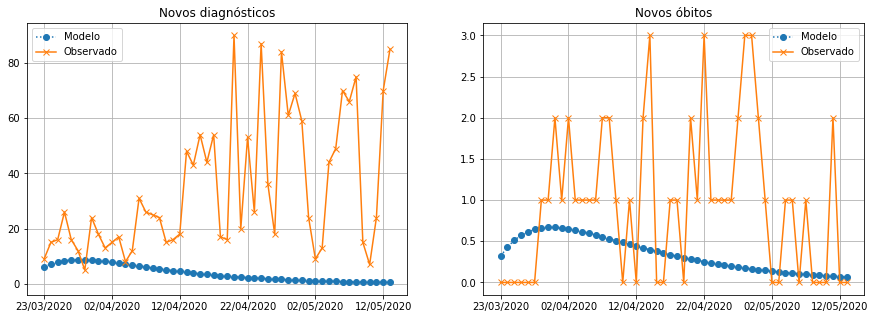

In [28]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5))

diagn = new_diagn(results_base.y, params)
ax1.plot(datas, diagn,        'o:', label='Modelo')
ax1.plot(datas, df_ts_novos[cidade_atual].values, 'x-', label='Observado')
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.grid()
ax1.legend()
ax1.set_title('Novos diagnósticos')
ax1.set_xticks(datas[::10])

obitos = new_deaths(results_base.y, params)
ax2.plot(datas, obitos,'o:', label = 'Modelo')
ax2.plot(datas, df_ts_novos_obitos[cidade_atual].values, 'x-', label='Observado')
ax2.grid()
ax2.legend()
ax2.set_title('Novos óbitos')
ax2.set_xticks(datas[::10])


plt.show()
